<a href="https://colab.research.google.com/github/nsedov/DLS2/blob/main/task3/RNN-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [1]:
# !pip install torchtext==0.9.0
# !pip install torch==1.8.0+cu111

# !pip install -U torch==1.8.0+cu111 torchtext==0.9.0 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
# # Reload environment
# exit()

In [2]:
import pandas as pd
import numpy as np
import torch

from torchtext.legacy import datasets

from torchtext.legacy.data import Field, LabelField
from torchtext.legacy.data import BucketIterator

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [3]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)  # Поле метки

In [4]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [5]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобьем на части

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.55MB/s]


In [6]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

In [8]:
next(iter(train_iter))


[torchtext.legacy.data.batch.Batch of size 64]
	[.text]:('[torch.cuda.LongTensor of size 115x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')
	[.label]:[torch.cuda.FloatTensor of size 64 (GPU 0)]

## RNN

Для начала попробуем использовать рекурентные нейронные сети. На семинаре вы познакомились с GRU, вы можете также попробовать LSTM. Можно использовать для классификации как hidden_state, так и output последнего токена.

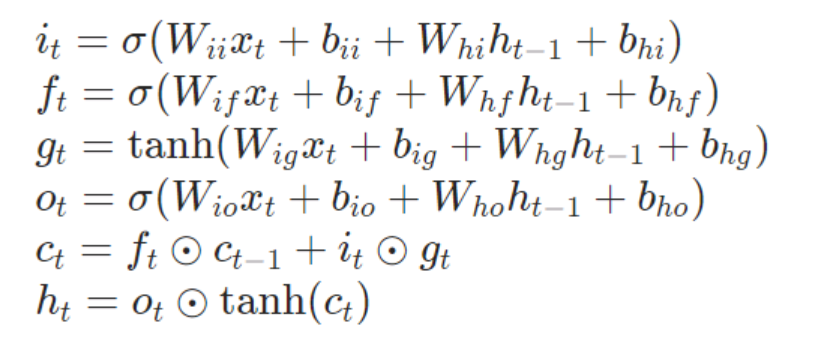

In [9]:
# class LSTM(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim):
#         super().__init__()

#         self.embedding_dim = embedding_dim
#         self.hidden_dim = hidden_dim

#         self.b_ii = nn.Parameter(torch.rand((1, hidden_dim)))
#         self.b_hi = nn.Parameter(torch.rand((1, hidden_dim)))
        
#         self.b_if = nn.Parameter(torch.rand((1, hidden_dim)))
#         self.b_hf = nn.Parameter(torch.rand((1, hidden_dim)))
        
#         self.b_ig = nn.Parameter(torch.rand((1, hidden_dim)))
#         self.b_hg = nn.Parameter(torch.rand((1, hidden_dim)))
        
#         self.b_io = nn.Parameter(torch.rand((1, hidden_dim)))
#         self.b_ho = nn.Parameter(torch.rand((1, hidden_dim)))
        
#         self.w_ii = nn.Parameter(torch.rand(embedding_dim, hidden_dim))
#         self.w_hi = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        
#         self.w_if = nn.Parameter(torch.rand(embedding_dim, hidden_dim))
#         self.w_hf = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        
#         self.w_ig = nn.Parameter(torch.rand(embedding_dim, hidden_dim))
#         self.w_hg = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        
#         self.w_io = nn.Parameter(torch.rand(embedding_dim, hidden_dim))
#         self.w_ho = nn.Parameter(torch.rand(hidden_dim, hidden_dim))


#     def forward(self, x, hidden=None):

#         seq_length = x.size(1)
#         if hidden is None:
#             hidden = torch.zeros((x.size(0), seq_length + 1, self.hidden_dim)).to(x.device)
#         if cell is None:
#             cell = torch.zeros((x.size(0), self.hidden_dim)).to(x.device)

#         for cur_idx in range(seq_length):

#             it = torch.sigmoid(
#                 self.w_ii @ x[:, cur_idx] + self.b_ii + self.w_hi @ hidden[:, cur_idx] + self.b_hi
#             )
#             ft = torch.sigmoid(
#                 self.w_if @ x[:, cur_idx] + self.b_if + self.w_hf @ hidden[:, cur_idx] + self.b_hf
#             )
#             gt = torch.tanh(
#                 self.w_ig @ x[:, cur_idx] + self.b_ig + self.w_hg @ hidden[:, cur_idx] + self.b_hg
#             )
#             ot = torch.sigmoid(
#                 self.w_io @ x[:, cur_idx] + self.b_io + self.w_ho @ hidden[:, cur_idx] + self.b_ho
#             )
#             cell = ft * cell + it * gt

#             hidden[cur_idx + 1] = ot * torch.tanh(cell)

#         return hidden

In [10]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional)
        
        if dropout is None:
            dropout = 0
        self.dropout = nn.Dropout(dropout)

        D = 1
        if bidirectional:
            D = 2
        
        self.fc1 = nn.Sequential(
            nn.Linear(hidden_dim * D, hidden_dim * D),
            nn.BatchNorm1d(hidden_dim * D),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim * D, hidden_dim * D),
            nn.BatchNorm1d(hidden_dim * D),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_dim * D, output_dim)
        
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        # cell arg for LSTM, remove for GRU
        output, (hidden, cell) = self.rnn(packed_embedded)
        #packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        #print(hidden.shape)
        if bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))  # YOUR CODE GOES HERE
        else:
            hidden = self.dropout(hidden[-1,:,:])
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        #hidden = [batch size, hid dim * num directions] or [batch_size, hid dim * num directions]
            
        return self.out(hidden)

Поиграйтесь с гиперпараметрами

In [16]:
vocab_size = len(TEXT.vocab)
emb_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 3
bidirectional = True
dropout = 0.4
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=4

In [17]:
model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

In [18]:
model = model.to(device)

In [19]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

max_epochs = 20

Обучите сетку! Используйте любые вам удобные инструменты, Catalyst, PyTorch Lightning или свои велосипеды.

In [20]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        opt.zero_grad()
        input_embeds = batch.text[0]
        txt_len = batch.text[1].cpu()
        label = batch.label.to(device).unsqueeze(1)
        prediction = model(input_embeds, txt_len)
        loss = loss_func(prediction, label)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        # YOUR CODE GOES HERE
        input_embeds = batch.text[0]
        label = batch.label.unsqueeze(1)
        txt_len = batch.text[1].cpu()
        prediction = model(input_embeds, txt_len)
        loss = loss_func(prediction, label)
        val_loss += loss.item()
    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.7010591869806722, Validation Loss: 0.6970228997327513


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.6961913134929908, Validation Loss: 0.6968367145223132


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.692182308348426, Validation Loss: 0.6759034955905656


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.6601951017867039, Validation Loss: 0.8444484224763967


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.598505128256596, Validation Loss: 0.5623378182871867


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.4521605898864078, Validation Loss: 0.4831949990179579


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.35669756936330865, Validation Loss: 0.3823660713131145


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.2835817760957854, Validation Loss: 0.3834965878118903


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.21873170004165085, Validation Loss: 0.37310004467933866


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.17946756124007004, Validation Loss: 0.4384559970033371


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

<All keys matched successfully>

In [22]:
from sklearn.metrics import f1_score
sum = 0.0
itr = 0
target = []
predictions = []
model.eval()
for batch in test_iter:
    input_embeds = batch.text[0]
    txt_len = batch.text[1].cpu()
    label = batch.label.cpu().tolist()
    prediction = model(input_embeds, txt_len)
    prediction = torch.sigmoid(prediction.detach().cpu().flatten()).numpy()
    prediction = np.rint(prediction).tolist()
    target.extend(label)
    predictions.extend(prediction)  
    itr += 1
score = f1_score(target, predictions)

In [23]:
score

0.8516879504362119

Посчитайте f1-score вашего классификатора на тестовом датасете.

**Ответ**: 0.85

## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [24]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 128, 128),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [26]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        dropout=0.5,
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv_0 = nn.Conv1d(in_channels = emb_dim, kernel_size = kernel_sizes[0], out_channels = out_channels)  # YOUR CODE GOES HERE
        
        self.conv_1 = nn.Conv1d(in_channels = emb_dim, kernel_size = kernel_sizes[1], out_channels = out_channels)  # YOUR CODE GOES HERE
        
        self.conv_2 = nn.Conv1d(in_channels = emb_dim, kernel_size = kernel_sizes[2], out_channels = out_channels)  # YOUR CODE GOES HERE
        
        self.fc = nn.Sequential(
            nn.Linear(len(kernel_sizes) * out_channels, out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Linear(out_channels, 1)
        )
        
        self.dropout = nn.Dropout(dropout)
        
   
    def forward(self, text):
        #print(text.shape)
        embedded = self.embedding(text)
        #print(embedded.shape)
        #embedded = embedded.view(128, -1, self.emb_dim)  # may be reshape here
        embedded = embedded.permute(0, 2, 1)
        #print(embedded.shape)
        conved_0 = F.relu(self.conv_0(embedded))  # may be reshape here
        conved_1 = F.relu(self.conv_1(embedded))  # may be reshape here
        conved_2 = F.relu(self.conv_2(embedded))  # may be reshape here
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        
        return self.fc(cat)

In [27]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels=128
dropout = 0.5
dim = 300
patience = 3
model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout)

In [28]:
model.to(device)

CNN(
  (embedding): Embedding(202630, 300)
  (conv_0): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
  (conv_1): Conv1d(300, 128, kernel_size=(4,), stride=(1,))
  (conv_2): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
  (fc): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [29]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

In [30]:
max_epochs = 30

Обучите!

In [31]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        opt.zero_grad()
        input_embeds = batch.text#.to(device)
        #label = batch.label.to(device).unsqueeze(1)
        label = batch.label.unsqueeze(1)
        prediction = model(input_embeds)
        loss = loss_func(prediction, label)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        # YOUR CODE GOES HERE
        # input_embeds = batch.text.to(device)
        # label = batch.label.to(device).unsqueeze(1)
        input_embeds = batch.text
        label = batch.label.unsqueeze(1)
        prediction = model(input_embeds)
        loss = loss_func(prediction, label)
        val_loss += loss.item()
    val_loss /= len(val_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.6771419579095214, Validation Loss: 0.5704936314437349


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.56411322581507, Validation Loss: 0.4918924145779367


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.48781777602912735, Validation Loss: 0.4340420668408022


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.419612806861418, Validation Loss: 0.3863570877050949


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.3518800315630697, Validation Loss: 0.36428439718181804


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.2839340861261326, Validation Loss: 0.34907602531425025


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.22643112516316183, Validation Loss: 0.3487397472737199


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.1683223385662928, Validation Loss: 0.3536296686378576


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.12152717028656145, Validation Loss: 0.3691415327080226


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

<All keys matched successfully>

In [32]:
from sklearn.metrics import f1_score
itr = 0
target = []
predictions = []
model.eval()
for batch in test_iter:
    input_embeds = batch.text
    label = batch.label.cpu().tolist()
    prediction = model(input_embeds)
    prediction = torch.sigmoid(prediction.detach().cpu().flatten()).numpy()
    prediction = np.rint(prediction).tolist()
    target.extend(label)
    predictions.extend(prediction)  
    itr += 1
score = f1_score(target, predictions)

In [33]:
score

0.8395737943429329

Посчитайте f1-score вашего классификатора.

**Ответ**: 8.84

## Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [34]:
!pip install -q captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00


In [35]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [36]:
def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [37]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 1.00 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([2.3105e-06], device='cuda:0', dtype=torch.float64)
pred:  pos ( 1.00 ) , delta:  tensor([7.5832e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([0.0003], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([9.0734e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.69 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)


Попробуйте добавить свои примеры!

In [38]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)
None

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,1.57,It was a fantastic performance ! pad
pos,neg (0.01),pos,1.03,Best film ever pad pad pad pad
pos,pos (1.00),pos,1.12,Such a great show! pad pad pad
neg,neg (0.00),pos,-0.38,It was a horrible movie pad pad
neg,neg (0.01),pos,0.28,I've never watched something as bad pad
neg,pos (0.69),pos,0.75,It is a disgusting movie! pad pad


## Эмбеддинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [39]:
TEXT.build_vocab(trn, vectors=GloVe(name='6B', dim=300))# YOUR CODE GOES HERE
# подсказка: один из импортов пока не использовался, быть может он нужен в строке выше :)
LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

.vector_cache/glove.6B.zip: 862MB [02:41, 5.33MB/s]                           
100%|█████████▉| 399999/400000 [00:31<00:00, 12561.51it/s]


In [40]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 128, 128),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [41]:
model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=64,
            kernel_sizes=kernel_sizes, dropout=dropout)

word_embeddings = TEXT.vocab.vectors

prev_shape = model.embedding.weight.shape

model.embedding.weight.data.copy_(word_embeddings) # инициализируйте эмбэдинги

assert prev_shape == model.embedding.weight.shape
model.to(device)

opt = torch.optim.Adam(model.parameters())

In [42]:
patience = 5

Вы знаете, что делать.

In [43]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

In [44]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    freeze_embeddings(model)
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        if epoch < 2:
                freeze_embeddings(model, True)

        opt.zero_grad()
        input_embeds = batch.text#.to(device)
        #label = batch.label.to(device).unsqueeze(1)
        label = batch.label.unsqueeze(1)
        prediction = model(input_embeds)
        loss = loss_func(prediction, label)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        # YOUR CODE GOES HERE
        input_embeds = batch.text
        label = batch.label.unsqueeze(1)
        prediction = model(input_embeds)
        loss = loss_func(prediction, label)
        val_loss += loss.item()

    val_loss /= len(val_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.603751519518177, Validation Loss: 0.4231370470281375


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.40014583960066746, Validation Loss: 0.36541440527317887


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.34081584421822625, Validation Loss: 0.36198862124297576


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.30316514886208695, Validation Loss: 0.3486362614874112


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.27366752041517384, Validation Loss: 0.3392963444782516


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.24122385789443107, Validation Loss: 0.3527263044300726


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.22237272125526067, Validation Loss: 0.377855350910607


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.19528118417645893, Validation Loss: 0.36907807043043234


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.1794879392442042, Validation Loss: 0.3894739623292018


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

<All keys matched successfully>

In [45]:
from sklearn.metrics import f1_score
itr = 0
target = []
predictions = []
model.eval()
for batch in test_iter:
    input_embeds = batch.text
    label = batch.label.cpu().tolist()
    prediction = model(input_embeds)
    prediction = torch.sigmoid(prediction.detach().cpu().flatten()).numpy()
    prediction = np.rint(prediction).tolist()
    target.extend(label)
    predictions.extend(prediction)  
    itr += 1
score = f1_score(target, predictions)

In [46]:
score

0.8544913741820345

Посчитайте f1-score вашего классификатора.

**Ответ**:0.86

Проверим насколько все хорошо!

In [47]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.98 ) , delta:  tensor([0.0023], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.18 ) , delta:  tensor([8.5031e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.97 ) , delta:  tensor([0.0003], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.04 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.47 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.02 ) , delta:  tensor([4.3498e-05], device='cuda:0', dtype=torch.float64)


In [48]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)
None

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.98),pos,1.34,It was a fantastic performance ! pad
pos,neg (0.18),pos,0.38,Best film ever pad pad pad pad
pos,pos (0.97),pos,1.33,Such a great show! pad pad pad
neg,neg (0.04),pos,-0.62,It was a horrible movie pad pad
neg,neg (0.47),pos,1.01,I've never watched something as bad pad
neg,neg (0.02),pos,-0.79,It is a disgusting movie! pad pad
